In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
import scipy.stats as stats
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics

In [2]:
#Set working directory
os.chdir('C:/Users/Best Lappy/Desktop/EDWISOR/Projects/2')
os.getcwd()

'C:\\Users\\Best Lappy\\Desktop\\EDWISOR\\Projects\\2'

In [3]:
#load dataset
df = pd.read_csv("day.csv", index_col = "dteday")

In [4]:
#Dropping the variables 'registered' and 'casual' as both sum is 'cnt'.Also dropping 'instant' as its of no use.
df = df.drop(['registered', 'casual', 'instant'], axis=1)

In [5]:
df.dtypes

season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

In [6]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
dteday,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [7]:
#Type conversion
numeric = ['temp', 'atemp', 'hum', 'windspeed']
cat = ['season','holiday','weekday','workingday','weathersit','yr','mnth']
df[cat] = df[cat].astype('category')

In [8]:
#missing value Analysis
df.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

In [9]:
#Checking for the best missing imputation method for further operations
df1 = df.copy()
#df = df1.copy()

In [10]:
df['hum'].iloc[29]

0.722174

In [11]:
#Actual value = 0.722174
#mean = 0.6277649123287666
#median = 0.62625

In [12]:
#Create missing value, a small test to identify which method is good for imputation
#df['hum'].iloc[29] = np.nan

In [13]:
#Mean Imputation
#df['hum'] = df['hum'].fillna(df['hum'].mean())
#df['hum'].iloc[29]

In [14]:
#Median Imputation
#df['hum'] = df['hum'].fillna(df['hum'].median())
#df['hum'].iloc[29]

In [15]:
#As it is found that mean is close to actual value. Hence we impute missing values with mean

# Outlier Analysis

Univariate Boxplots: Boxplots for all Numerical Variables also for target variable

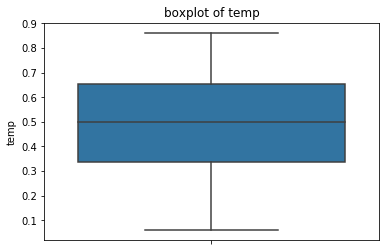

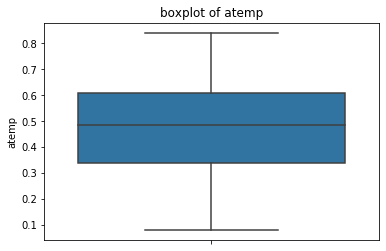

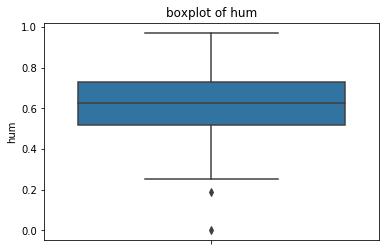

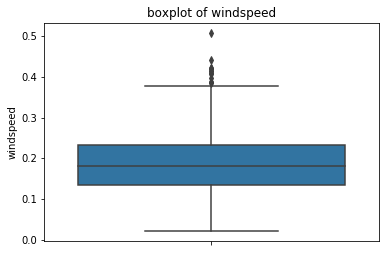

In [16]:
for i in numeric:
    sns.boxplot(y=i, data = df)
    plt.title("boxplot of " +i)
    #plt.savefig('Boxplot'+str(i)+'.png')
    plt.show()

Bivariate Boxplots: Boxplots for all Numerical Variables Vs all Categorical Variables

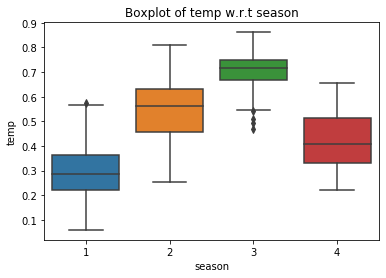

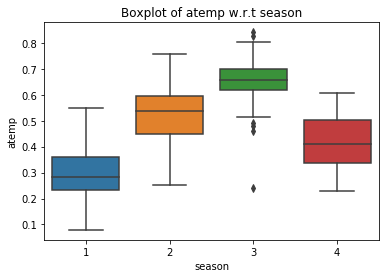

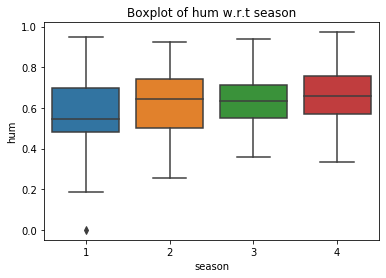

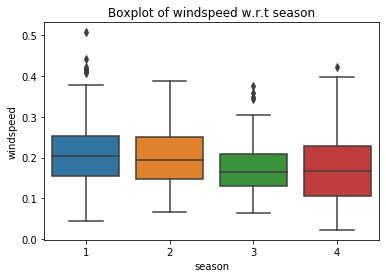

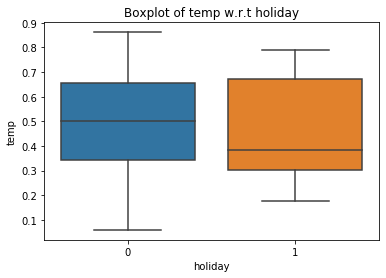

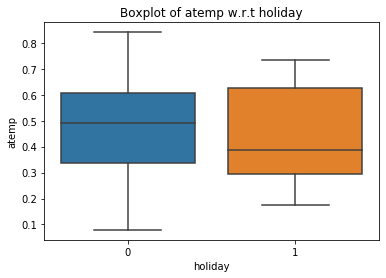

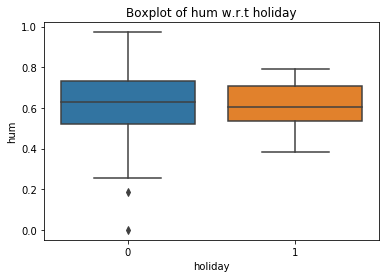

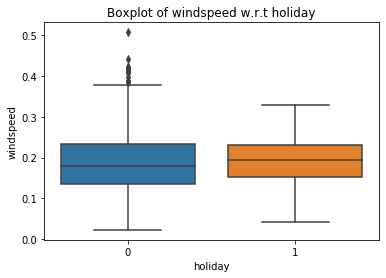

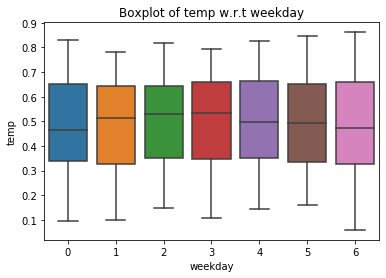

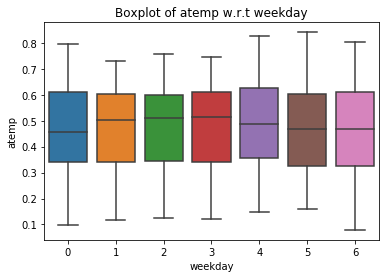

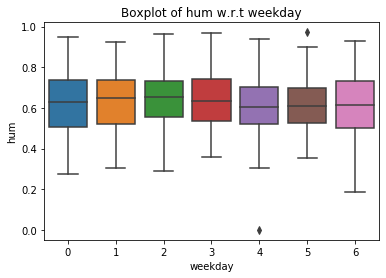

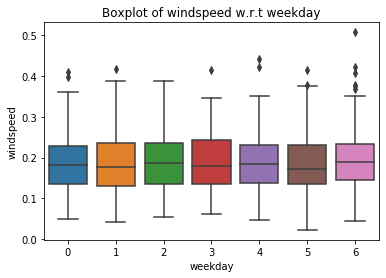

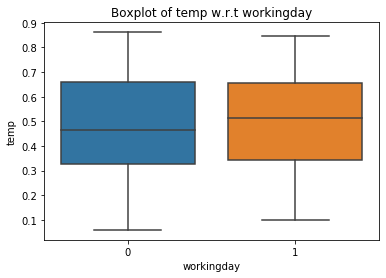

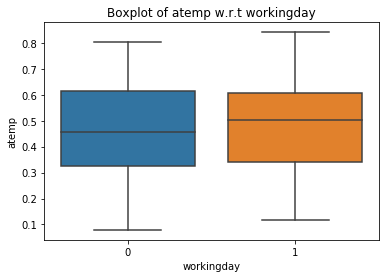

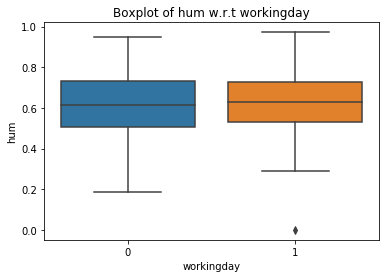

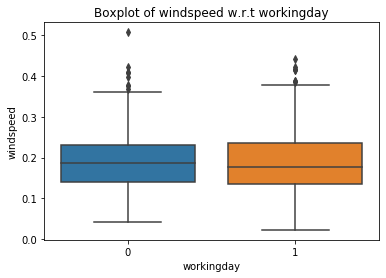

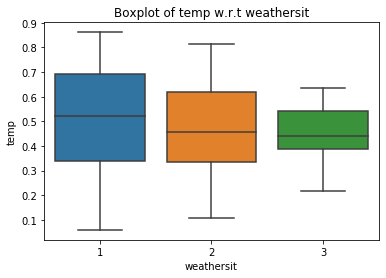

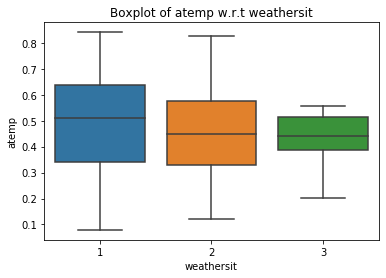

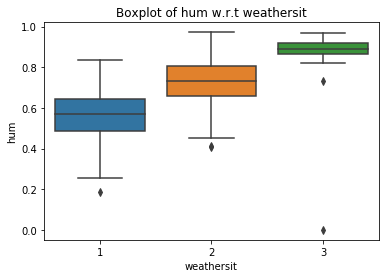

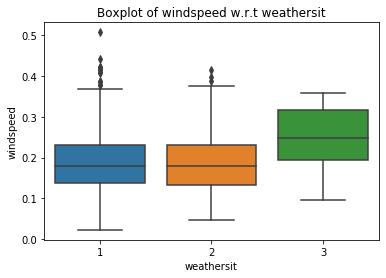

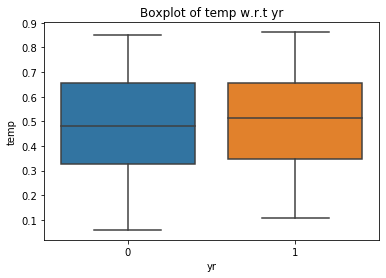

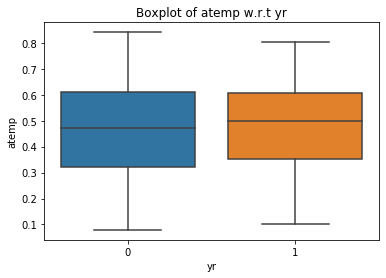

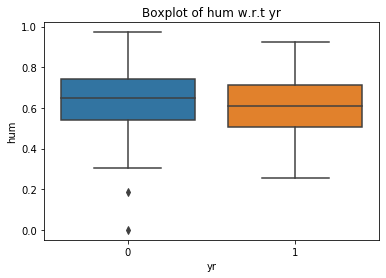

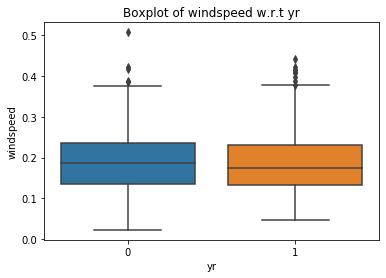

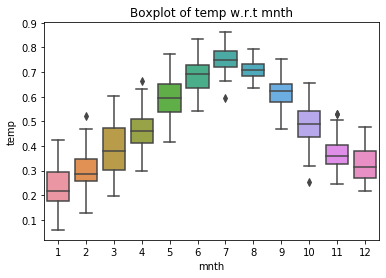

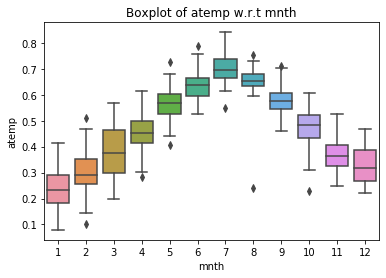

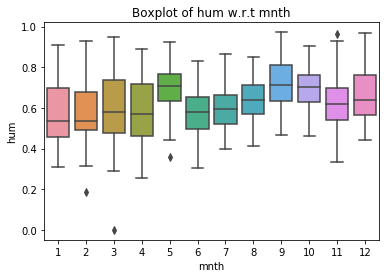

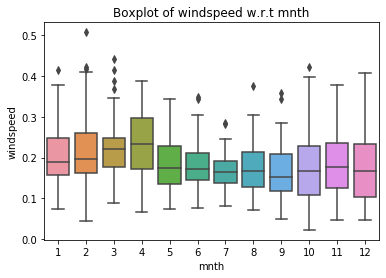

In [17]:
for i in cat:
    for j in numeric:
        sns.boxplot(x = i, y = j, data = df)
        plt.title('Boxplot of '+j+' w.r.t '+i)
        #plt.savefig('Boxplot of '+str(j)+' w.r.t '+str(i)+'.png')
        plt.show()

As we can see from the above Boxplots only 'hum' and 'windspeed' columns in the dataset has outliers

In [18]:
def outlier_treatment(col):
    #Extract quartiles
    q75, q25 = np.percentile(df[col], [75, 25])
    #Calculate IQR
    IQR = q75-q25
    #Calculate inner and outer fence
    minimum = q25 - (1.5*IQR)
    maximum = q75 + (1.5*IQR)
    #Replace with NA
    df.loc[df[col] < minimum,col] = np.nan
    df.loc[df[col] > maximum,col] = np.nan

In [19]:
outlier_treatment('hum')
outlier_treatment('windspeed')

In [20]:
df.isnull().sum()

season         0
yr             0
mnth           0
holiday        0
weekday        0
workingday     0
weathersit     0
temp           0
atemp          0
hum            2
windspeed     13
cnt            0
dtype: int64

In [21]:
#As mean is the best imputation method, we impute the missing values(Outliers) with mean.
df['hum'] = df['hum'].fillna(df['hum'].mean())
df['windspeed'] = df['windspeed'].fillna(df['windspeed'].mean())

# Feature Selection

#Corelation analysis for all numerical variables
-> We will plot a Heatmap of correlation whereas, correlation measures how strongly 2 quantities are related to each other.
-> We go for correlation to avoid redundant information in our model development

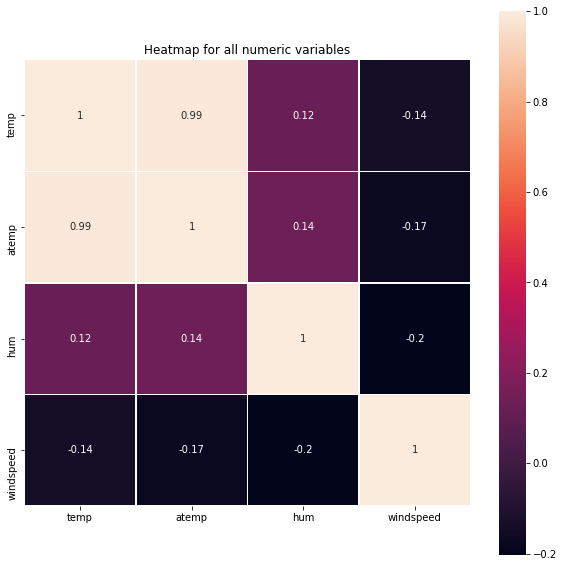

In [22]:
#Heatmap using corelation matrix
plt.figure(figsize = (10,10))
sns.heatmap(df[numeric].corr(),linewidths=0.5,linecolor='w',square=True,annot=True)
plt.title("Heatmap for all numeric variables")
#plt.savefig('corelation.png')
plt.show()

#From the above plot we found that 'temp' and 'atemp' are very highly corelated with each other.

#Chi Square test of independence for all Categorical variables.

Hypothesis testing :
     *Null Hypothesis: 2 variables are independent.
     *Alternate Hypothesis: 2 variables are not independent.
-> If p-value is less than 0.05 then we reject the null hypothesis saying that 2 variables are dependent.
->And if p-value is greater than 0.05 then we accept the null hypothesis saying that 2 variables are independent.
->There should be no dependencies between Independent variables.
->So we will remove that variable whose p-value with other variable is low than 0.05.
->And we will keep that variable whose p-value with other variable is high than 0.05

In [23]:
#Loop for chi square test
for i in cat:
    for j in cat:
        if(i!=j):
            chi2,p,dof,ex = chi2_contingency(pd.crosstab(df[i], df[j]))
            if(p < 0.05):
                print(i,"and",j,"are dependent on each other with",p,'----Remove')
            else:
                print(i,"and",j,"are independent on each other with",p,'----Keep')

season and holiday are independent on each other with 0.6831687073042003 ----Keep
season and weekday are independent on each other with 0.9999999999988407 ----Keep
season and workingday are independent on each other with 0.8865568364019545 ----Keep
season and weathersit are dependent on each other with 0.021179301044733697 ----Remove
season and yr are independent on each other with 0.9999288084245916 ----Keep
season and mnth are dependent on each other with 0.0 ----Remove
holiday and season are independent on each other with 0.6831687073042005 ----Keep
holiday and weekday are dependent on each other with 8.567055344615667e-11 ----Remove
holiday and workingday are dependent on each other with 4.033370935452143e-11 ----Remove
holiday and weathersit are independent on each other with 0.6008572213448835 ----Keep
holiday and yr are independent on each other with 0.9949247279855291 ----Keep
holiday and mnth are independent on each other with 0.5593083086035064 ----Keep
weekday and season are

Variables which are dependent on each other based on p-values are:
-> season and weathersit with p value 0.021179
-> season and mnth with p value 0.0
-> holiday and weekday with p value 8.567055344615667e-11
-> holiday and workingday with p value 4.033370935452143e-11
-> weekday and holiday with p value 8.567055344615637e-11
-> weekday and workingday with p value 6.775030505809736e-136
-> workingday and holiday with p value 4.033370935452143e-11
-> workingday and weekday with p value 6.775030505809736e-136
-> weathersit and season with p value 0.02117930104473366
-> weathersit and mnth with p value 0.014637111771019196
-> mnth and season with p value 0.0
-> mnth and weathersit with p value 0.014637111771019196
So besides season,holiday and yr we will remove weekday,weathersit,workingday,mnth.

In [24]:
#Copy data
df2 = df.copy()
#df = df2.copy()

In [25]:
df = df.drop(['mnth','weekday','weathersit','workingday'],axis = 1)

In [26]:
df.head()

,season,yr,holiday,temp,atemp,hum,windspeed,cnt
dteday,,,,,,,,
2011-01-01,1,0,0,0.344167,0.363625,0.805833,0.160446,985
2011-01-02,1,0,0,0.363478,0.353739,0.696087,0.248539,801
2011-01-03,1,0,0,0.196364,0.189405,0.437273,0.248309,1349
2011-01-04,1,0,0,0.200000,0.212122,0.590435,0.160296,1562
2011-01-05,1,0,0,0.226957,0.229270,0.436957,0.186900,1600


# Feature Scaling

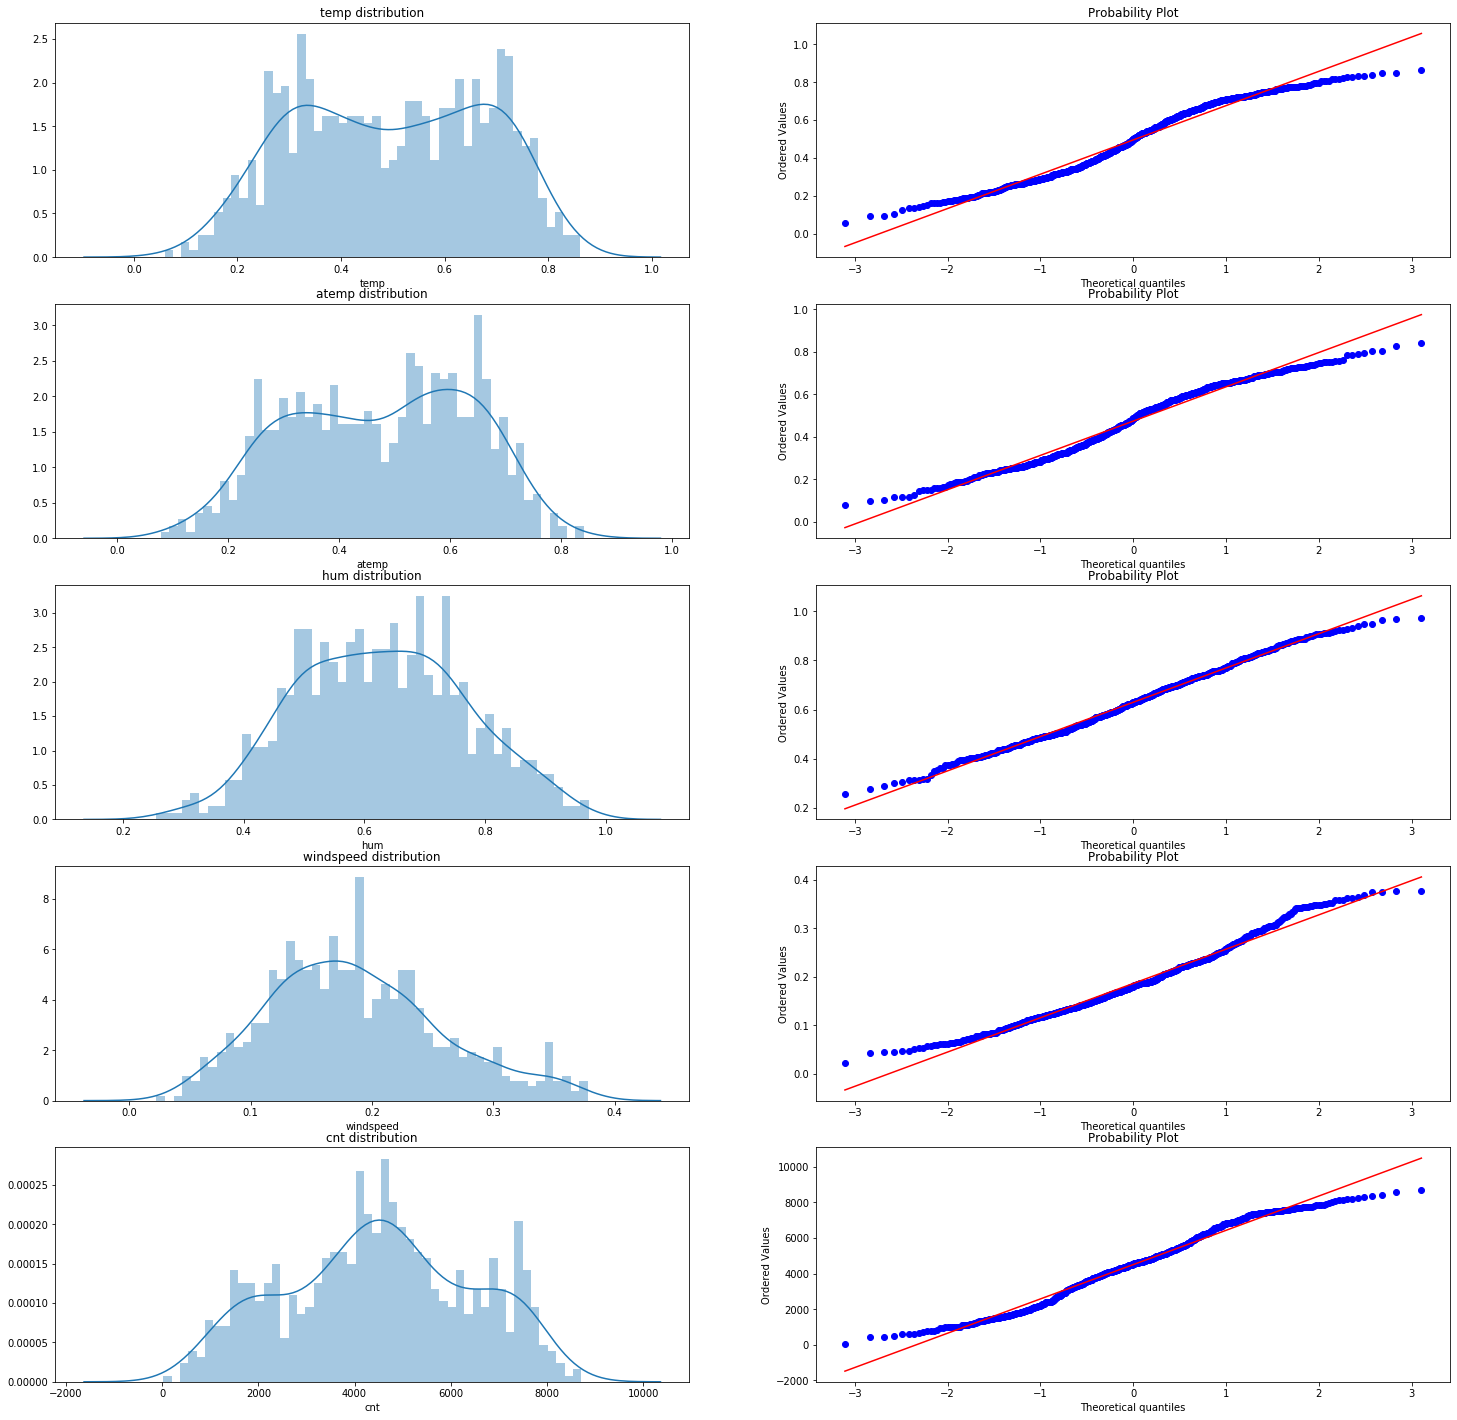

In [27]:
#Normality check by plotting distplot and probplot
fig,ax = plt.subplots(nrows=5,ncols=2)
fig.set_size_inches(25, 25)
sns.distplot(df['temp'],bins =50,ax = ax[0][0])
ax[0][0].set(title="temp distribution")
_ = stats.probplot(df['temp'], dist='norm', fit=True,plot=ax[0][1])
ax[0][1].set(title="Probability Plot")
sns.distplot(df['atemp'],bins =50,ax = ax[1][0])
ax[1][0].set(title="atemp distribution")
_ = stats.probplot(df['atemp'], dist='norm', fit=True,plot=ax[1][1])
ax[1][1].set(title="Probability Plot")
sns.distplot(df['hum'],bins =50,ax = ax[2][0])
ax[2][0].set(title="hum distribution")
_ = stats.probplot(df['hum'], dist='norm', fit=True,plot=ax[2][1])
ax[2][1].set(title="Probability Plot")
sns.distplot(df['windspeed'],bins =50,ax = ax[3][0])
ax[3][0].set(title="windspeed distribution")
_ = stats.probplot(df['windspeed'], dist='norm', fit=True,plot=ax[3][1])
ax[3][1].set(title="Probability Plot")
sns.distplot(df['cnt'],bins =50,ax = ax[4][0])
ax[4][0].set(title="cnt distribution")
_ = stats.probplot(df['cnt'], dist='norm', fit=True,plot=ax[4][1])
ax[4][1].set(title="Probability Plot")
#plt.savefig('Distribution before Normaliation.png')
plt.show()

In [28]:
#Normalization
for i in numeric:
    print(i)
    df[i] = (df[i] - min(df[i]))/(max(df[i]) - min(df[i]))

temp
atemp
hum
windspeed


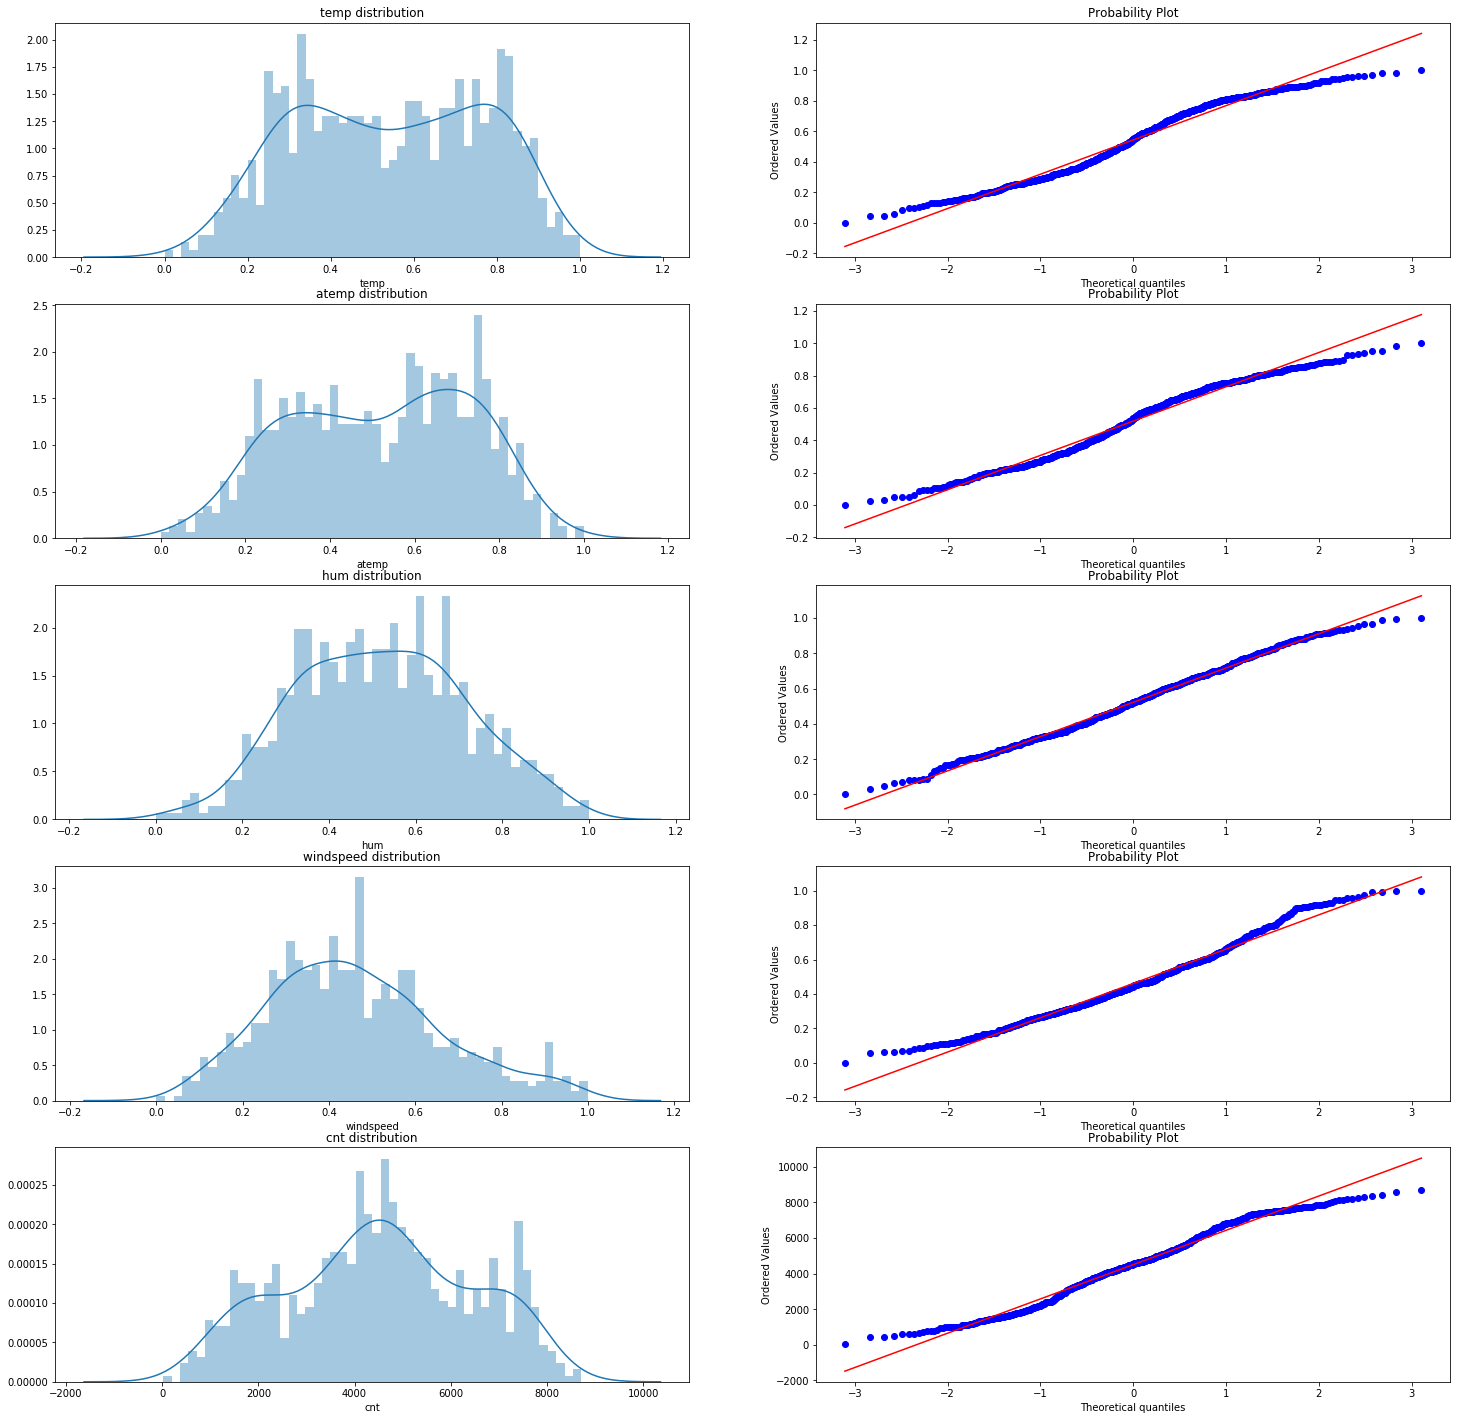

In [29]:
#After normalization.
fig,ax = plt.subplots(nrows=5,ncols=2)
fig.set_size_inches(25, 25)
sns.distplot(df['temp'],bins =50,ax = ax[0][0])
ax[0][0].set(title="temp distribution")
_ = stats.probplot(df['temp'], dist='norm', fit=True,plot=ax[0][1])
ax[0][1].set(title="Probability Plot")
sns.distplot(df['atemp'],bins =50,ax = ax[1][0])
ax[1][0].set(title="atemp distribution")
_ = stats.probplot(df['atemp'], dist='norm', fit=True,plot=ax[1][1])
ax[1][1].set(title="Probability Plot")
sns.distplot(df['hum'],bins =50,ax = ax[2][0])
ax[2][0].set(title="hum distribution")
_ = stats.probplot(df['hum'], dist='norm', fit=True,plot=ax[2][1])
ax[2][1].set(title="Probability Plot")
sns.distplot(df['windspeed'],bins =50,ax = ax[3][0])
ax[3][0].set(title="windspeed distribution")
_ = stats.probplot(df['windspeed'], dist='norm', fit=True,plot=ax[3][1])
ax[3][1].set(title="Probability Plot")
sns.distplot(df['cnt'],bins =50,ax = ax[4][0])
ax[4][0].set(title="cnt distribution")
_ = stats.probplot(df['cnt'], dist='norm', fit=True,plot=ax[4][1])
ax[4][1].set(title="Probability Plot")
#plt.savefig('Distribution after Normaliation.png')
plt.show()

# Multicollinearity Test

VIF is always greater or equal to 1.
if VIF is 1 --- Not correlated to any of the variables.
if VIF is between 1-5 --- Moderately correlated.
if VIF is above 5 --- Highly correlated.
If there are multiple variables with VIF greater than 5, only remove the variable with the highest VIF.

In [30]:
df.head()

,season,yr,holiday,temp,atemp,hum,windspeed,cnt
dteday,,,,,,,,
2011-01-01,1,0,0,0.355170,0.373517,0.767981,0.388102,985
2011-01-02,1,0,0,0.379232,0.360541,0.615202,0.635752,801
2011-01-03,1,0,0,0.171000,0.144830,0.254904,0.635105,1349
2011-01-04,1,0,0,0.175530,0.174649,0.468123,0.387681,1562
2011-01-05,1,0,0,0.209120,0.197158,0.254464,0.462471,1600


In [31]:
outcome, predictors = dmatrices('cnt ~ +season+ yr +holiday + temp+atemp + hum + windspeed',df, return_type='dataframe')

# calculating VIF for each individual Predictors
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif["features"] = predictors.columns
vif

,VIF,features
0,26.826131,Intercept
1,2.624139,season[T.2]
2,4.636714,season[T.3]
3,1.838976,season[T.4]
4,1.029142,yr[T.1]
5,1.003707,holiday[T.1]
6,70.103298,temp
7,66.209110,atemp
8,1.112156,hum
9,1.134103,windspeed


From above Dataframe we see that there is Multicollinearity in our Data
temp and atemp has highest VIF value hence are highly correlated.

# Feature Engineering

we know that temp and atemp are both temperature values and are very highly correlated with each other.
we will aggregate those 2 columns and derive a new feature.

In [32]:
columns = ['temp','atemp']
df['mean_temp'] = df.apply(lambda row: row[columns].mean(), axis=1)

In [33]:
df['mean_temp']

dteday
2011-01-01    0.364343
2011-01-02    0.369886
2011-01-03    0.157915
2011-01-04    0.175090
2011-01-05    0.203139
                ...   
2012-12-27    0.218367
2012-12-28    0.236489
2012-12-29    0.228190
2012-12-30    0.222725
2012-12-31    0.192413
Name: mean_temp, Length: 731, dtype: float64

Now that we have derived a new Column 'mean_temp' we can drop 'temp' and 'atemp

In [34]:
df = df.drop(['atemp', 'temp'], axis = 1)

In [35]:
df.head()

,season,yr,holiday,hum,windspeed,cnt,mean_temp
dteday,,,,,,,
2011-01-01,1,0,0,0.767981,0.388102,985,0.364343
2011-01-02,1,0,0,0.615202,0.635752,801,0.369886
2011-01-03,1,0,0,0.254904,0.635105,1349,0.157915
2011-01-04,1,0,0,0.468123,0.387681,1562,0.175090
2011-01-05,1,0,0,0.254464,0.462471,1600,0.203139


In [36]:
cat = ['season', 'holiday', 'yr']
#Creating dummies for categorical variables
for i in cat:
    ''' Creating dummies for each variable in cat and merging dummies dataframe to our original dataframe '''
    temp = pd.get_dummies(df[i], prefix = i)
    df = df.join(temp)

In [37]:
df.columns

Index(['season', 'yr', 'holiday', 'hum', 'windspeed', 'cnt', 'mean_temp',
       'season_1', 'season_2', 'season_3', 'season_4', 'holiday_0',
       'holiday_1', 'yr_0', 'yr_1'],
      dtype='object')

In [38]:
#We will remove some variables which were used to generate one hot encoding variables
df = df.drop(['season','holiday','yr'],axis = 1)

In [39]:
df.head()

,hum,windspeed,cnt,mean_temp,season_1,season_2,season_3,season_4,holiday_0,holiday_1,yr_0,yr_1
dteday,,,,,,,,,,,,
2011-01-01,0.767981,0.388102,985,0.364343,1,0,0,0,1,0,1,0
2011-01-02,0.615202,0.635752,801,0.369886,1,0,0,0,1,0,1,0
2011-01-03,0.254904,0.635105,1349,0.157915,1,0,0,0,1,0,1,0
2011-01-04,0.468123,0.387681,1562,0.175090,1,0,0,0,1,0,1,0
2011-01-05,0.254464,0.462471,1600,0.203139,1,0,0,0,1,0,1,0


# Model Development

In [40]:
from sklearn import tree
from sklearn.model_selection import train_test_split

In [41]:
df.iloc[:,2]

dteday
2011-01-01     985
2011-01-02     801
2011-01-03    1349
2011-01-04    1562
2011-01-05    1600
              ... 
2012-12-27    2114
2012-12-28    3095
2012-12-29    1341
2012-12-30    1796
2012-12-31    2729
Name: cnt, Length: 731, dtype: int64

In [42]:
df.nunique()

hum          594
windspeed    638
cnt          696
mean_temp    729
season_1       2
season_2       2
season_3       2
season_4       2
holiday_0      2
holiday_1      2
yr_0           2
yr_1           2
dtype: int64

In [43]:
target_cnt = df.iloc[:,2]
target_cnt.head()

dteday
2011-01-01     985
2011-01-02     801
2011-01-03    1349
2011-01-04    1562
2011-01-05    1600
Name: cnt, dtype: int64

#Splitting data into train and test

In [44]:
feature = df.drop(['cnt'],axis=1)
feature.head()

,hum,windspeed,mean_temp,season_1,season_2,season_3,season_4,holiday_0,holiday_1,yr_0,yr_1
dteday,,,,,,,,,,,
2011-01-01,0.767981,0.388102,0.364343,1,0,0,0,1,0,1,0
2011-01-02,0.615202,0.635752,0.369886,1,0,0,0,1,0,1,0
2011-01-03,0.254904,0.635105,0.157915,1,0,0,0,1,0,1,0
2011-01-04,0.468123,0.387681,0.175090,1,0,0,0,1,0,1,0
2011-01-05,0.254464,0.462471,0.203139,1,0,0,0,1,0,1,0


In [45]:
train_size = int(0.80 * df.shape[0]) # train_size = 584
train_features = feature[:train_size]
train_target_cnt = target_cnt[:train_size]
test_features = feature[train_size:]
test_target_cnt = target_cnt[train_size:]
print(df.shape, train_features.shape, test_features.shape,train_target_cnt.shape,test_target_cnt.shape)

(731, 12) (584, 11) (147, 11) (584,) (147,)


In [46]:
pd.DataFrame(test_features).tail()

,hum,windspeed,mean_temp,season_1,season_2,season_3,season_4,holiday_0,holiday_1,yr_0,yr_1
dteday,,,,,,,,,,,
2012-12-27,0.555105,0.921356,0.218367,1,0,0,0,1,0,0,1
2012-12-28,0.467517,0.374116,0.236489,1,0,0,0,1,0,0,1
2012-12-29,0.694316,0.286721,0.228190,1,0,0,0,1,0,0,1
2012-12-30,0.319025,0.923102,0.222725,1,0,0,0,1,0,0,1
2012-12-31,0.450116,0.372359,0.192413,1,0,0,0,1,0,0,1


Regression metrics for our Models:

r square
MAE(Mean Absolute Error)
MSE(Mean square Error)
RMSE(Root Mean Square Error)

In [47]:
def scores(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-train_features.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_))) 
def test_scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(train_features)
    scores(train_target_cnt,y_pred)
    print()
    print('<<<------------------- Test Data Score --------------------->')
    print()
    # Evaluating on Test Set
    y_pred = model.predict(test_features)
    scores(test_target_cnt,y_pred)

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Linear Regression

In [49]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'copy_X':[True, False],
          'fit_intercept':[True,False]}
# Instantiate a Decision reg classifier: reg
reg = LinearRegression()

# Instantiate the gridSearchCV object: reg_cv
reg_cv = GridSearchCV(reg, param_dist, cv=5,scoring='r2')

# Fit it to the data
reg_cv.fit(feature, target_cnt)

# Print the tuned parameters and score
print("Tuned Decision reg Parameters: {}".format(reg_cv.best_params_))
print("Best score is {}".format(reg_cv.best_score_))

Tuned Decision reg Parameters: {'copy_X': True, 'fit_intercept': False}
Best score is 0.32130976079473167


In [50]:
# Instantiate a reg regressor: reg
reg = LinearRegression(copy_X= True, fit_intercept=False)

# Fit the regressor to the data
reg.fit(train_features,train_target_cnt)
test_scores(reg)

<<<------------------- Training Data Score --------------------->

r square   0.8192789600830531
Adjusted r square:0.8158035554692656
MAPE:18.82331986033174
MSE: 577338.5002617418
RMSE: 759.8279412220518

<<<------------------- Test Data Score --------------------->

r square   0.555929018558811
Adjusted r square:0.5197454571080475
MAPE:165.67416822840883
MSE: 1560554.5670585278
RMSE: 1249.2215844511045


# Decision Tree Regression

In [51]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': range(2,16,2),
              'min_samples_split': range(2,16,2)}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeRegressor()

# Instantiate the gridSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(feature, target_cnt)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 4, 'min_samples_split': 4}
Best score is -0.07643340870481896


In [52]:
# Instantiate a tree regressor: tree
tree = DecisionTreeRegressor(max_depth= 6, min_samples_split=4)

# Fit the regressor to the data
tree.fit(train_features,train_target_cnt)
# Make predictions and cal error
test_scores(tree)

<<<------------------- Training Data Score --------------------->

r square   0.9122819012498239
Adjusted r square:0.9105950147353974
MAPE:12.174632179114866
MSE: 280227.6680209003
RMSE: 529.3653445597854

<<<------------------- Test Data Score --------------------->

r square   0.6033108563739535
Adjusted r square:0.5709880372636831
MAPE:165.177644208212
MSE: 1394045.2780298332
RMSE: 1180.6969458882465


# Random Forest Regression

In [53]:
# Create the random grid
random_grid = {'n_estimators': range(100,500,100),
               'max_depth': range(10,20,1),
               'min_samples_split':range(2,5,1)}
# Instantiate a Decision Forest classifier: Forest
Forest = RandomForestRegressor()

# Instantiate the gridSearchCV object: Forest_cv
Forest_cv = GridSearchCV(Forest, random_grid, cv=5)

# Fit it to the data
Forest_cv.fit(feature, target_cnt)

# Print the tuned parameters and score
print("Tuned Decision Forest Parameters: {}".format(Forest_cv.best_params_))
print("Best score is {}".format(Forest_cv.best_score_))

Tuned Decision Forest Parameters: {'max_depth': 18, 'min_samples_split': 2, 'n_estimators': 100}
Best score is 0.31606561812439565


In [57]:
# Instantiate a Forest regressor: Forest
Forest = RandomForestRegressor(max_depth= 18, min_samples_split=2,n_estimators=100)
# Fit the regressor to the data
Forest.fit(train_features,train_target_cnt)
test_scores(Forest)

<<<------------------- Training Data Score --------------------->

r square   0.9818754581516048
Adjusted r square:0.9815269092699049
MAPE:6.237381938345435
MSE: 57901.37005349546
RMSE: 240.62703516748792

<<<------------------- Test Data Score --------------------->

r square   0.5606841432066707
Adjusted r square:0.5248880363568439
MAPE:167.65675158113643
MSE: 1543844.104550784
RMSE: 1242.5152331262518


We have selected Random Forest Regression as our Best Model to Predict Bike Rental Count.

Lets compare the distribution of train and test results. More or less the distribution of train and test looks identical.

In [58]:
test_predicted = Forest.predict(test_features)
pd.DataFrame(test_predicted,index = test_target_cnt.index,columns=['cnt']).head()

,cnt
dteday,
2012-08-07,7251.7600
2012-08-08,7296.6200
2012-08-09,6647.7185
2012-08-10,6376.3400
2012-08-11,6547.3200


In [59]:
pd.DataFrame(test_target_cnt,columns=['cnt']).head()

,cnt
dteday,
2012-08-07,7273
2012-08-08,7534
2012-08-09,7286
2012-08-10,5786
2012-08-11,6299
